In [92]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm

### Audio Features
- Zero Cross Rate
- Energy
- Entropy of Energy
- Spectral Centroid
- Spectral Spread
- Spectral Entropy
- Spectral Flux
- Spectral Roll off
- MFCC
- Chroma Vector
- Chroma Deviation

## Utility function to extract features from wav files

* Pre-process data and transform double channel to single channel
* Extract the chromagraph  from the audio file
* Find note frequency

In [4]:
# audioFeatureExtraction.stFeatureExtraction?

In [5]:
def preProcess(fileName):
    
    # Extracting wav file data
    [Fs, x] = audioBasicIO.readAudioFile(fileName); #Fs - Framerate/ sampling frequency in Hz

    # If double/stereo channel data then take mean
    if( len( x.shape ) > 1 and  x.shape[1] == 2 ):
        x = np.mean( x, axis = 1, keepdims = True )
    else:
        x = x.reshape( x.shape[0], 1 )
    
    # Extract the raw chromagram data, expected dimention is [ m,  ] not [ m, 1 ]
    F, f_names = audioFeatureExtraction.stFeatureExtraction(
        x[ :, 0 ], #signal
        Fs, #the sampling freq (in Hz)
        0.050*Fs, #the short-term window size (in samples)
        0.025*Fs #the short-term window step (in samples)
    )
    
    return (f_names, F)

In [6]:
feature_name, features = preProcess( "./sample_data_audio/c1_2.wav" )

In [26]:
print("Avalable features: ", feature_name)
print("-------------------------------------------------")
print("Total features : ",  len(feature_name))
print("Shapes of features: ", features.shape)

Avalable features:  ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std']
-------------------------------------------------
Total features :  34
Shapes of features:  (34, 229)
Feature 21:  chroma_1
Feature 21 shape:  (229,)


### Chroma Vector
It is a representation of how humans relate colors to notes. In other words we think of same notes but from two different octaves to be of the same color. Thus we have 12 possible values at each window. 

A, A#, B, C, C#, D, D#, E, F, F#, G and G#. 


Of course they are not mutually exclusive hence for a given time fame one can have more than one note. But to keep things simple we will only select the most prominent note for a particular window. Let us visualize the chroma vector using a chromagram.

In [29]:
print("Feature 21: ", feature_name[21])
print("Feature 21 shape: ", features[21].shape)

Feature 21:  chroma_1
Feature 21 shape:  (229,)


In [27]:
def getChromagram(audioData):
    
    # chronograph_1
    temp_data =  audioData[21].reshape(1, audioData[21].shape[0])
    chronograph = temp_data
    
    # looping through the next 11 stacking them vertically
    for i in range(22, 33): #chroma_1 to chroma_11
        temp_data =  audioData[i].reshape(1, audioData[i].shape[0])
        chronograph = np.vstack([chronograph, temp_data])
    
    return chronograph

In [28]:
chromagram = getChromagram(features)
chromagram.shape

(12, 229)

In [53]:
def getNoteFrequency(chromagram):
    
    # Total number of time frames in the current sample
    numberOfWindows = chromagram.shape[1] #12
    
    # Taking the note with the highest amplitude
    freqVal = chromagram.argmax( axis = 0 )
    
    # Converting the freqVal vs time to freq count
    histogram, bin = np.histogram( freqVal, bins = 12 ) 
    
    # Normalizing the distribution by the number of time frames
    normalized_hist = histogram.reshape( 1, 12 ).astype( float ) / numberOfWindows
    
    return normalized_hist

In [54]:
noteFrequency = getNoteFrequency(chromagram)
noteFrequency.shape

(1, 12)

## Utility function to plot a heat map and frequency of each note

In [55]:
def plotHeatmap(chromagraph, smallSample = True):
    
    notesLabels = ["G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A"]
    
    fig, axis = plt.subplots()
    
    if smallSample:
        im = axis.imshow(chromagram[:, 0 : 25], cmap = "YlGn")
    else:
        im = axis.imshow(chromagram)
        
    cbar = axis.figure.colorbar(im, ax = axis, cmap = "YlGn")
    cbar.ax.set_ylabel("Amplitude", rotation=-90, va="bottom")
    
    axis.set_yticks(np.arange(len(notesLabels)))
    axis.set_yticklabels(notesLabels)
    
    axis.set_title("chromagram")
    
    fig.tight_layout()
    _ = plt.show()

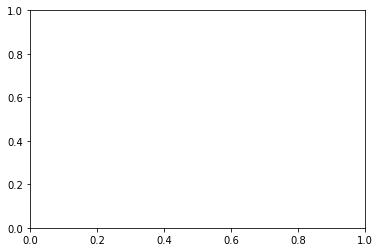

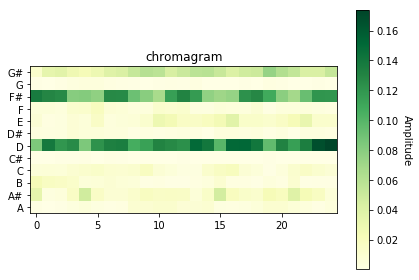

In [56]:
plotHeatmap(chromagram)

As we can see, there is indeed more than one note being hit in the same time window.

In [57]:
def noteFrequencyPlot(noteFrequency, smallSample=True):
    fig, axis = plt.subplots(1, 1, sharey=True)
    axis.plot(np.arange(1, 13), noteFrequency[0, :])
    _ = plt.show()

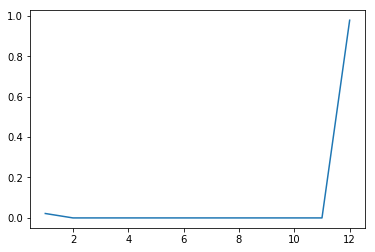

In [58]:
noteFrequencyPlot(noteFrequency)

For example in this image, the 12th note was hit the most as compared to other notes. So finally we will be left with a (1x12) vector representing a data point. This will form the basic unit of our data set.

## Dataset  generator
This function iterates over all the available files and converts them into note frequency arrays which is out feature set for each audio file.

In [126]:
fileList = []

def getDataset(filePath):
    X = pd.DataFrame()
    
    columns=["G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A"]
    
    for root, dirs, filenames in os.walk(filePath):
        for file in sorted(filenames):
            print("Workin on file: ", file)
            fileList.append(file)
            feature_name, features = preProcess(filePath + file)
            chromagram = getChromagram(features)
            noteFrequency = getNoteFrequency(chromagram) # 1x12
            x_new = pd.Series(noteFrequency[0, :])
            X = pd.concat([X, x_new], axis=1) # 12 x 10 ; 10-files

    data = X.T.copy() # 10 x 12
    data.columns = columns
    data.index = [i for i in range(0, data.shape[0])]
            
    return data

In [127]:
data = getDataset("./sample_data_audio/")

Workin on file:  c1_1.wav
Workin on file:  c1_2.wav
Workin on file:  c2_1.wav
Workin on file:  c2_2.wav
Workin on file:  c2_3.wav
Workin on file:  c2_4.wav
Workin on file:  c3_1.wav
Workin on file:  c3_2.wav
Workin on file:  c4_1.wav
Workin on file:  c4_2.wav


## A peek into the dataset

Each row represents a file and each column represents the frequency distribution of notes

In my case, I have 10 files in total.

In [128]:
data

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A
0,0.097561,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.902439
1,0.021834,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.978166
2,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000
3,0.015385,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.984615
4,0.027027,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.972973
5,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000
6,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000
7,0.090909,0.0,0.0,0.090909,0.0,0.0,0.545455,0.0,0.0,0.0,0.0,0.272727
8,0.991713,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.008287
9,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000


## K-means explanation

The algorithm in itself is pretty simple:

1. Initialize all k centroids.
2. Loop step 3 and 4 for given number of epochs
3. Label the data-points with the closest centroid.
4. Recalculate the centroids by taking the mean of all the data-sets with same labels.    
    
$$
p = a_1i + b_1j + ... + l_1t \\
q = a_2i + b_2j + ... + l_2t \\
distance(p,q) = \sqrt{(a_1-a_2)^2 + (b_1-b_2)^2 + ... + (l_1-l_2)^2}
$$


Now to visualize what K-means is doing in each iteration, let us consider the data set to be 2D. Let k = 3.   
The algorithm first initializes 3 random centroids.    
Now the training loop starts and for each iteration, it paints each point in the data set with the color of the centroid that is closest (least distance) to it.   
When that is done, new centroids are calculated by taking the mean of the points with the same color. This animation shows the algorithm at work.  


![](kmeans.gif)



### Hyper-parameters

In [139]:
# Number of cluster we wish to divide the data into( user tunable )
k = 4

# Max number of allowed iterations for the algorithm( user tunable )
epochs = 2000

### K-means utility functions

In [181]:
def initilizeCentroids(data, k):
    '''
    Initilize cluster centroids( assuming random k data points to be centroid return them )
    Given data and k, return the first k data points and these k points will act as initial centroids.
    '''
    centroids = data[:k] #this supposed to be random points, for simplicity we taking from data. If you get Nan go for random!
#     centroids = np.random.rand(k, data.shape[1]) #again when I triwe get NaN still, so I soted the files such that we have some good initial points
    return centroids

In [182]:
centroids = initilizeCentroids(data, k)
centroids

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A
0,0.097561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.902439
1,0.021834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.978166
2,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
3,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984615


In [183]:
X = tf.placeholder(dtype=tf.float32, shape=data.shape) # 10x12
C = tf.placeholder(dtype=tf.float32, shape=(k,data.shape[1])) # kx12
C_labels = tf.placeholder(dtype=tf.int32) # 

# utility to assign centroids to examples
# https://www.coursera.org/lecture/neural-networks-deep-learning/broadcasting-in-python-uBuTv
expanded_vectors = tf.expand_dims(X, 0) # 1X10x12
expanded_centroids = tf.expand_dims(C, 1) # kx1x12

print(expanded_vectors)
print(expanded_centroids)

Tensor("ExpandDims_36:0", shape=(1, 10, 12), dtype=float32)
Tensor("ExpandDims_37:0", shape=(4, 1, 12), dtype=float32)


$$
p = a_1i + b_1j + ... + l_1t \\
q = a_2i + b_2j + ... + l_2t \\
distance(p,q) = \sqrt{(a_1-a_2)^2 + (b_1-b_2)^2 + ... + (l_1-l_2)^2}
$$


We wish to subtract each data point with each centroid to find the distance between them, then select the centroid that gave the least distance for each data point.

Thus we will do (Kx10) distance calculations, and for each calculation, we will process 12 features for each vector.    
Notice that the 3rd dimension is same for both — 12. Thus each data point is copied K times in the 1st dimension, and each centroid is copied 19 times in the 2nd dimension.    
Thus subtracting the two on axis=2, will give us (Kx10) elements each having 12 features in the 3rd dimension.

In [184]:
distance = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), axis = 2) # kx10
getCentroidsOp = tf.argmin(distance, 0)

In [185]:
print(distance)
print(getCentroidsOp)

Tensor("Sum_12:0", shape=(4, 10), dtype=float32)
Tensor("ArgMin_12:0", shape=(10,), dtype=int64)


https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum


In [186]:
# utility to recalculate centroids
# This adds up the feature vectors of the data points with same label id. Will end up giving K feature vectors.
sums = tf.unsorted_segment_sum(X, C_labels, k) # K
 # This will do the same thing as the above step but instead of adding the feature vectors of data points, we add ones. 
#This will be used to take the mean of the K feature vectors generated in the above step finally giving us the new centroids.
counts = tf.unsorted_segment_sum(tf.ones_like(X), C_labels, k )
# Dividing the two tensors to generate the new centroids.
reCalculateCentroidsOp = tf.divide(sums,  counts)

In [187]:
print(sums)
print(counts)
print(reCalculateCentroidsOp)

Tensor("UnsortedSegmentSum_23:0", dtype=float32)
Tensor("UnsortedSegmentSum_24:0", dtype=float32)
Tensor("truediv_11:0", dtype=float32)


### Driver function

In [188]:
centroids = []
data_labels = []

with tf.Session() as sess:
    
    # Initilize all tensor flow variables
    sess.run(tf.global_variables_initializer())
    
    # Get initial list of k centroids
    centroids = initilizeCentroids(data, k)
    
    for epoch in tqdm(range(epochs)):
        data_labels =  sess.run(getCentroidsOp, feed_dict={X:data, C:centroids})
        centroids = sess.run( reCalculateCentroidsOp, feed_dict={X:data, C_labels:data_labels})
    
print(data_labels)
print("------------------------")
print(centroids)

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))


[1 3 2 3 3 2 2 2 0 2]
------------------------
[[0.9917127  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.00828729]
 [0.09756097 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.902439  ]
 [0.01818182 0.         0.         0.01818182 0.         0.
  0.9090909  0.         0.         0.         0.         0.05454545]
 [0.02141523 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.97858477]]


In [189]:
final_labels = pd.DataFrame( { "Labels": data_labels, "File Names": fileList } )
final_labels

,Labels,File Names
0,1,c1_1.wav
1,3,c1_2.wav
2,2,c2_1.wav
3,3,c2_2.wav
4,3,c2_3.wav
5,2,c2_4.wav
6,2,c3_1.wav
7,2,c3_2.wav
8,0,c4_1.wav
9,2,c4_2.wav


**References**
- https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225